#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/mini_project_3'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
train_data = pd.read_csv(path + '/data01_train.csv')
test_data = pd.read_csv(path + '/data01_test.csv')
feature_data = pd.read_csv(path + '/features.csv')
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
train_data['is_dynamic'] = np.where(np.isin(train_data['Activity'], ['STANDING', 'SITTING', 'LAYING']), 0, 1)
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


### (2) x, y 분리

In [ ]:
x = train_data.drop(['Activity', 'is_dynamic'], axis=1)
y = train_data.loc[:, ['Activity', 'is_dynamic']]

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=1, test_size=0.2)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [ ]:
model1 = Sequential([Dense(32, activation='relu', input_shape=(x_train.shape[1], )),
                     Dense(16, activation='relu'),
                     Dense(1, activation='sigmoid')])
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,529 (72.38 KB)

 Trainable params: 18,529 (72.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy')
history = model1.fit(x_train, y_train['is_dynamic'], validation_split=0.3, epochs=20).history

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2205 - val_loss: 0.0066
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 6.4934e-04
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 4.1260e-04
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5095e-04 - val_loss: 8.1618e-04
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 5.0583e-04
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.6553e-04 - val_loss: 2.2922e-04
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9325e-04 - val_loss: 5.9946e-04
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6916e-04 - val_loss: 1.6472e-04
Epoch 12

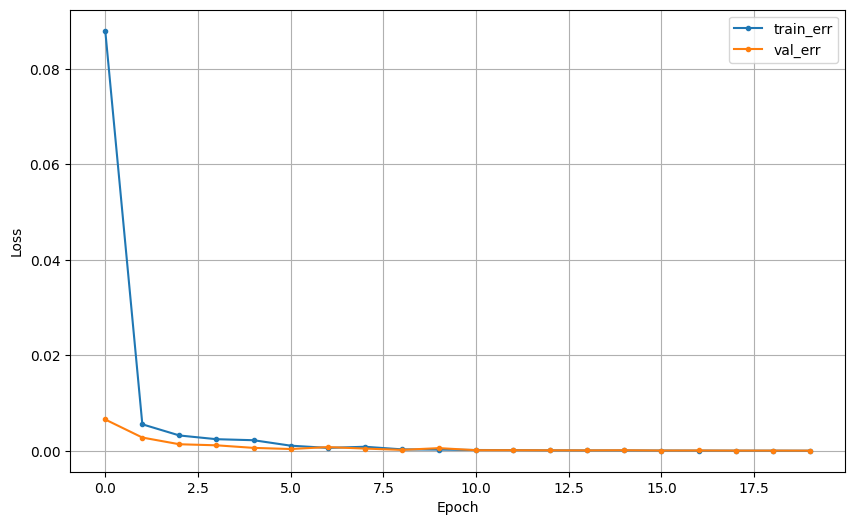

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model1.predict(x_val)
pred = np.where(pred >= 0.5, 1, 0)
print(classification_report(y_val['is_dynamic'], pred))
pred = model1.predict(x_train)
pred = np.where(pred >= 0.5, 1, 0)
print(classification_report(y_train['is_dynamic'], pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       1.00      1.00      1.00       522

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2579
           1       1.00      1.00      1.00      2125

    accuracy                           1.00      4704
   macro avg       1.00      1.00      1.00      4704
weighted avg       1.00      1.00      1.00      4704



#### 모델1-2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         287,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 357,569 (1.36 MB)

 Trainable params: 357,569 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

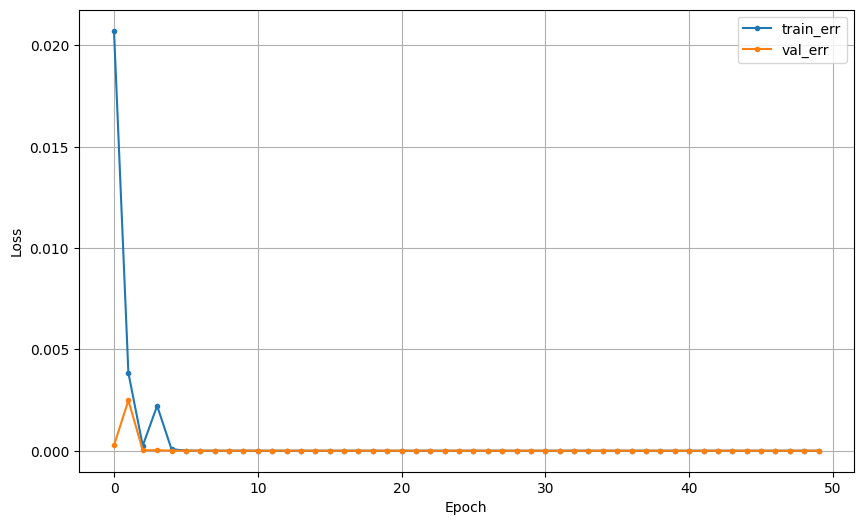

In [ ]:
clear_session()
model1 = Sequential([Input(shape=(x_train.shape[1],)),
                     Dense(512, activation = 'relu'),
                     Dense(128, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(1, activation = 'sigmoid')])

model1.summary()

model1.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

hist = model1.fit(x_train, y_train['is_dynamic'], epochs = 50, validation_split = 0.2, verbose=False).history

dl_history_plot(hist)


#### 2) 모델2

In [ ]:
model2 = Sequential([Dense(32, activation='relu', input_shape=(x_train.shape[1], )),
                     Dropout(0.1),
                     Dense(32, activation='relu'),
                     Dropout(0.1),
                     Dense(8, activation='relu'),
                     Dense(3, activation='softmax')])
model2.summary()
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,331 (75.51 KB)

 Trainable params: 19,331 (75.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3 = Sequential([Dense(32, activation='relu', input_shape=(x_train.shape[1], )),
                     Dropout(0.1),
                     Dense(3, activation='softmax')])
model3.summary()
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 32)                  │          17,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,083 (70.64 KB)

 Trainable params: 18,083 (70.64 KB)

 Non-trainable params: 0 (0.00 B)

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
train_data['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [ ]:
train_data1 = train_data[train_data['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])]
train_data2 = train_data[train_data['Activity'].isin(['WALKING_UPSTAIRS', 'WALKING', 'WALKING_DOWNSTAIRS'])]

In [ ]:
x_1 = train_data1.drop(['Activity', 'is_dynamic'], axis=1)
y_1 = train_data1.loc[:, 'Activity']

x_2 = train_data2.drop(['Activity', 'is_dynamic'], axis=1)
y_2 = train_data2.loc[:, 'Activity']

In [ ]:
y_2.unique()

array(['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'], dtype=object)

In [ ]:
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_1, y_1, random_state=1, test_size=0.2)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_2, y_2, random_state=1, test_size=0.2)

In [ ]:
encoder1 = LabelEncoder()
y_train1 = encoder1.fit_transform(y_train1)
y_val1 = encoder1.transform(y_val1)

encoder2 = LabelEncoder()
y_train2 = encoder2.fit_transform(y_train2)
y_val2 = encoder2.transform(y_val2)

In [ ]:
x_train1.shape, x_train.shape

((2587, 561), (4704, 561))

In [ ]:
history = model2.fit(x_train1, y_train1, epochs=50, validation_split=0.2).history

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0318 - val_loss: 0.7499
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7516 - val_loss: 0.5240
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5715 - val_loss: 0.4117
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4857 - val_loss: 0.3386
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3828 - val_loss: 0.2796
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3508 - val_loss: 0.3009
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3193 - val_loss: 0.2279
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2825 - val_loss: 0.1832
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2545 - val_loss: 0.1653
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2309 - val_loss: 0.1491
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1931 - val_loss: 0.1277
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1830 - val_lo

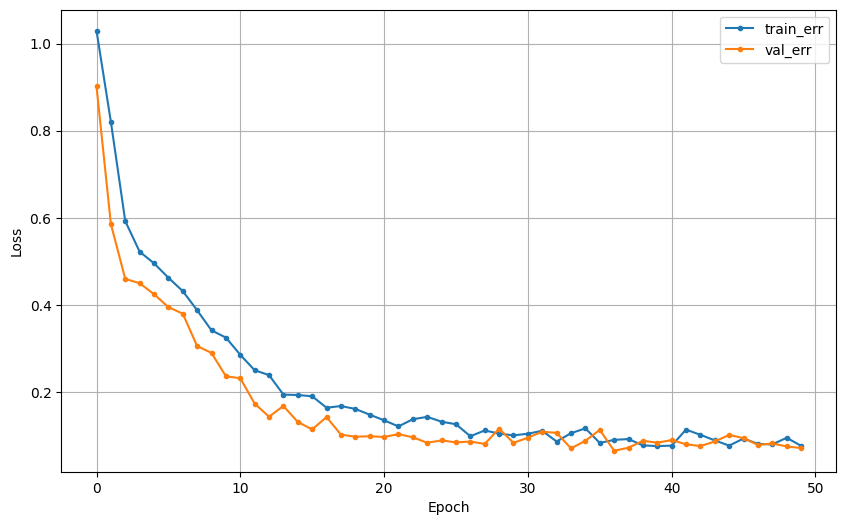

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model2.predict(x_val1)
pred = pred.argmax(axis=1)
print(confusion_matrix(y_val1, pred))
print(classification_report(y_val1, pred))
print(accuracy_score(y_val1,pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[204   0   0]
 [  1 212   7]
 [  0  19 204]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.92      0.96      0.94       220
           2       0.97      0.91      0.94       223

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647

0.9582689335394127


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
y_train

0

In [ ]:
history = model3.fit(x_train2, y_train2, epochs=50, validation_split=0.2).history

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9633 - val_loss: 0.3982
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3536 - val_loss: 0.2151
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2087 - val_loss: 0.1467
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1638 - val_loss: 0.1077
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1095 - val_loss: 0.1123
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0882 - val_loss: 0.0816
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676 - val_loss: 0.0739
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - val_loss: 0.0612
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - val_loss: 0.0569
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444 - val_loss: 0.0592
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429 - val_loss: 0.0479
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333 - val_lo

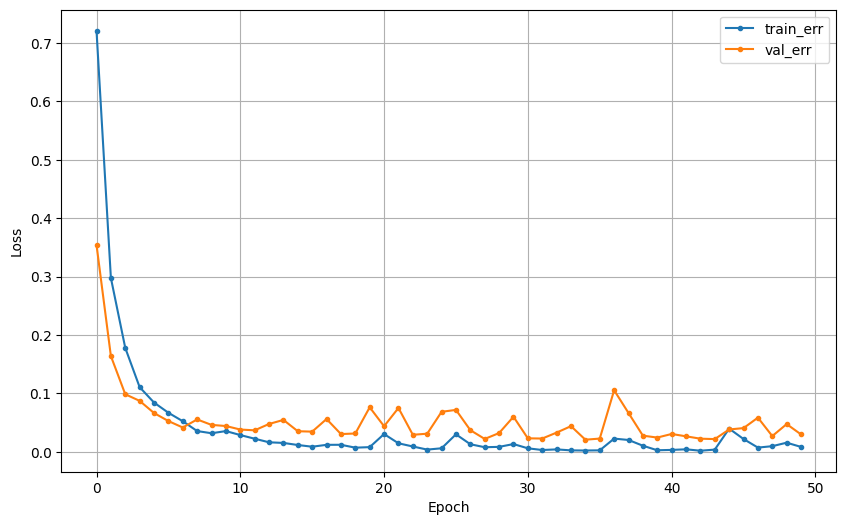

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model3.predict(x_val2)
pred = pred.argmax(axis=1)
print(classification_report(y_val2, pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.99      0.99      0.99       163
           2       0.99      0.99      0.99       153

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530



In [ ]:
model2_2 = Sequential([Input(shape = (x_train2.shape[1], )),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(64, activation='relu'),
                    Dropout(0.1),
                    Dense(16, activation = 'relu'),
                    Dense(3, activation='softmax')])

model2_2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
es2_2 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10)
history = model2_2.fit(x_train2, y_train2, epochs=100, validation_split=0.2, callbacks = [es2_2]).history

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.7348 - val_loss: 0.1389
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1304 - val_loss: 0.0825
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0595 - val_loss: 0.0797
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0535 - val_loss: 0.0435
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - val_loss: 0.0612
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412 - val_loss: 0.0437
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0180 - val_loss: 0.0345
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0305 - val_loss: 0.0335
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0267 - val_loss: 0.0276
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.0482
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - val_loss: 0.0291
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

In [ ]:
pred = model2_2.predict(x_val2)
pred = pred.argmax(axis=1)
print(classification_report(y_val2, pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.99      1.00      1.00       163
           2       1.00      0.99      0.99       153

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
def func(data, model_1, model_2, model_3):
  data['is_dynamic'] = np.where(np.isin(data['Activity'], ['STANDING', 'SITTING', 'LAYING']), 0, 1)

  x = test_data.drop(['Activity', 'is_dynamic'], axis=1)
  y = test_data.loc[:, 'Activity']
  y_dynamic = test_data.loc[:, 'is_dynamic']
  scaler = MinMaxScaler()
  x = scaler.fit_transform(x)

  pred = model_1.predict(x)
  pred = np.where(pred >= 0.5, 1, 0)
  print('단계1 : ', accuracy_score(y_dynamic, pred))
  x1 = x[np.where(pred == 0)[0]]
  x2 = x[np.where(pred == 1)[0]]
  print(len(x2))
  pred1 = model_2.predict(x1)
  pred2 = model_3.predict(x2)

  pred1 = pred1.argmax(axis=1)
  pred2 = pred2.argmax(axis=1)
  print(np.bincount(pred2))
  pred1 = encoder1.inverse_transform(pred1)
  pred2 = encoder2.inverse_transform(pred2)

  y_pred1 = y.iloc[np.where(pred == 0)[0]]
  y_pred2 = y.iloc[np.where(pred == 1)[0]]
  print(y_pred2.unique())
  print('정적 동작 : ', accuracy_score(y_pred1, pred1))
  print(confusion_matrix(y_pred1, pred1))

  print('동적 동작 : ', accuracy_score(y_pred2, pred2))
  print(confusion_matrix(y_pred2, pred2))

  final_predictions = pd.Series(index=y.index, dtype=object)

  final_predictions.loc[np.where(pred == 0)[0]] = pred1
  final_predictions.loc[np.where(pred == 1)[0]] = pred2

  accuracy = accuracy_score(y, final_predictions)
  print(classification_report(y, final_predictions))
  return accuracy, final_predictions

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
accuracy, predictions = func(test_data, model1, model2, model2_2)
print(accuracy)

In [ ]:
predictions, test_data['Activity']
pd.concat([predictions, test_data['Activity']], axis=1)[40:100]

,0,Activity
40,STANDING,STANDING
41,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
42,WALKING,WALKING
43,WALKING,WALKING_UPSTAIRS
44,STANDING,STANDING
45,SITTING,SITTING
46,LAYING,LAYING
47,LAYING,LAYING
48,LAYING,LAYING
49,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
